In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as mtick

In [3]:
rates=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical rates', header=1)
portfolio=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical portfolio', header=1)

In [4]:
ftp=rates.iloc[:,:6]
euribor=rates.iloc[:,7:]

In [7]:
new_column_names = {'3Y.1': '3Y', '5Y.1': '5Y', '10Y.1': '10Y'}

# Rename columns
euribor.rename(columns=new_column_names, inplace=True)

<ipython-input-24-a6fa8802cc8e>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  average_yield = euribor.mean(axis=0)


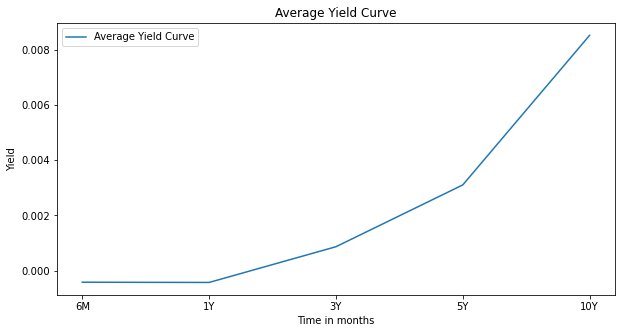

In [24]:
# STYLIZED FACT 1
# Calculate the average yield for each maturity
average_yield = euribor.mean(axis=0)

# Create a plot
plt.figure(figsize=(10, 5))
plt.plot(euribor.columns[1:], average_yield, label='Average Yield Curve')

plt.xlabel('Time in months')
plt.ylabel('Yield')
plt.title('Average Yield Curve')

plt.legend()

plt.show()

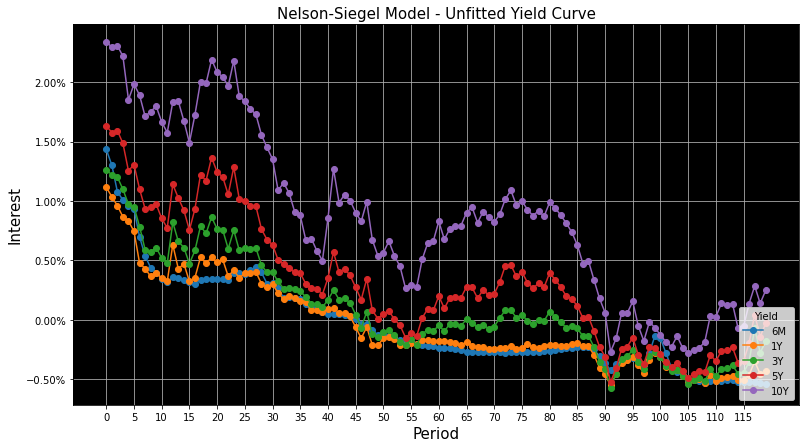

In [25]:
sf = euribor.copy()
sf = sf.dropna()
sf1 = sf.copy()
sf1['Y'] = round(sf['6M']*100, 4)

# Define columns to plot
columns_to_plot = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Plotting
fig, ax = plt.subplots(figsize=(13, 7))
plt.title("Nelson-Siegel Model - Unfitted Yield Curve", fontsize=15)
ax.set_facecolor("black")
fig.patch.set_facecolor('white')

# Plot each column
for col in columns_to_plot:
    X = sf1.index
    Y = sf1[col] * 100  # Convert to percentage
    plt.plot(X, Y, label=f"{col}", marker="o")

plt.xlabel('Period', fontsize=15)
plt.ylabel('Interest', fontsize=15)
plt.xticks(np.arange(0, 120, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(title="Yield", loc="lower right")
plt.grid()
plt.show()

In [11]:
# STYLIZED FACT 3-5
# voor het maken van de tabel om de stylized facts te checken met autocorrelation
def lagSeries(column, lag):
    return column.shift(lag)

def autoCorrelation(series, lag):
    lag_series = lagSeries(series, lag)
    return series.corr(lag_series)

def makeTable():
    table = []
    maturities = ['6M','1Y','3Y','5Y','10Y']
    for maturity in maturities:
        series = euribor[maturity]
        row = {"maturity": maturity,
              "mean": series.mean(),
               "std": series.std(),
               "rho_1": autoCorrelation(series,1),
               "rho_6": autoCorrelation(series,6),
               "rho_12": autoCorrelation(series,12)}
        table.append(row)
    return pd.DataFrame(table)

print(makeTable().round(3))

  maturity   mean    std  rho_1  rho_6  rho_12
0       6M -0.000  0.004  0.994  0.922   0.879
1       1Y -0.000  0.004  0.985  0.925   0.918
2       3Y  0.001  0.004  0.980  0.905   0.842
3       5Y  0.003  0.005  0.978  0.882   0.762
4      10Y  0.009  0.007  0.981  0.883   0.740


In [12]:
# STYLIZED FACT 6
# Calculate cross-correlations


correlations = euribor.corr()

print(correlations)

           6M        1Y        3Y        5Y       10Y
6M   1.000000  0.978877  0.945785  0.906102  0.869265
1Y   0.978877  1.000000  0.983605  0.954711  0.924067
3Y   0.945785  0.983605  1.000000  0.990970  0.968453
5Y   0.906102  0.954711  0.990970  1.000000  0.989733
10Y  0.869265  0.924067  0.968453  0.989733  1.000000


In [15]:
# Function to calculate cross-correlation with optional lag
def crossCorrelation(series1, series2, lag=0):
    lag_series = series2.shift(lag)
    return series1.corr(lag_series)
crossCorrelation(euribor['1Y'], euribor['3Y'], lag=0)

0.9836051135888911

### Dynamic Nelson Siegel

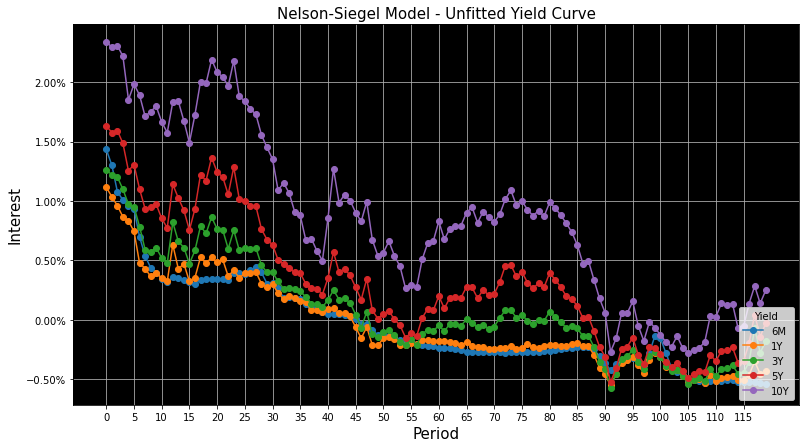

In [26]:
sf = euribor.copy()
sf = sf.dropna()
sf1 = sf.copy()
sf1['Y'] = round(sf['6M']*100, 4)

# Define columns to plot
columns_to_plot = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Plotting
fig, ax = plt.subplots(figsize=(13, 7))
plt.title("Dynamic Nelson-Siegel Model - Unfitted Yield Curve", fontsize=15)
ax.set_facecolor("black")
fig.patch.set_facecolor('white')

# Plot each column
for col in columns_to_plot:
    X = sf1.index
    Y = sf1[col] * 100  # Convert to percentage
    plt.plot(X, Y, label=f"{col}", marker="o")

plt.xlabel('Period', fontsize=15)
plt.ylabel('Interest', fontsize=15)
plt.xticks(np.arange(0, 120, 5))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(title="Yield", loc="lower right")
plt.grid()
plt.show()


In [27]:
def create_ns_matrix(tau, lamb):
    tau = np.atleast_1d(tau)
    lamb = np.atleast_1d(lamb)
    ns_matrix = np.zeros((len(tau), 3))

    for i in range(len(tau)):
        ns_matrix[i, 0] = 1
        ns_matrix[i, 1] = (1 - np.exp(-lamb * tau[i])) / (lamb * tau[i])
        ns_matrix[i, 2] = ns_matrix[i, 1] - np.exp(-lamb * tau[i])

    ns_df = pd.DataFrame(ns_matrix, columns=['1', '(1-e^-λτ)/λτ', '(1-e^-λτ)/λτ - e^-λτ'])
    return ns_df

def estimate_betas(Y, tau_example, lambda_example):
    B = create_ns_matrix(tau_example, lambda_example)
    BBi = np.linalg.inv(B.T @ B)
    betas = np.linalg.inv(B.T @ B) @ B.T @ Y.T

    beta1 = betas.iloc[0, :]
    beta2 = betas.iloc[1, :]
    beta3 = betas.iloc[2, :]

    cs = []
    phis = []

    for beta in [beta1, beta2, beta3]:
        beta_lagged = beta[:-1].values
        beta_current = beta[1:].values
        beta_lagged_with_constant = sm.add_constant(beta_lagged)
        model = sm.OLS(beta_current, beta_lagged_with_constant)
        results = model.fit()

        c_estimate = results.params[0]
        phi_estimate = results.params[1]

        cs.append(c_estimate)
        phis.append(phi_estimate)

    beta1s = list(beta1.values)
    beta1_np = np.zeros(len(test_data.iloc[:, 1]))

    for i in range(len(test_data.iloc[:, 1])):
        beta1s.append(cs[0] + phis[0] * beta1s[-1])
        beta1_np[i] = cs[0] + phis[0] * beta1s[-1]

    beta2s = list(beta2.values)
    beta2_np = np.zeros(len(test_data.iloc[:, 1]))

    for i in range(len(test_data.iloc[:, 1])):
        beta2s.append(cs[1] + phis[1] * beta2s[-1])
        beta2_np[i] = cs[1] + phis[1] * beta2s[-1]

    beta3s = list(beta3.values)
    beta3_np = np.zeros(len(test_data.iloc[:, 1]))

    for i in range(len(test_data.iloc[:, 1])):
        beta1s.append(cs[2] + phis[2] * beta3s[-1])
        beta3_np[i] = cs[2] + phis[2] * beta3s[-1]

    betas = np.row_stack((beta1_np, beta2_np, beta3_np))
    return B, betas

# Sample data setup
train_data = euribor.iloc[:66, 1:]
test_data = euribor.iloc[66:, 1:]

# Define maturities
maturities = ["6M", "1Y", "3Y", "5Y", "10Y"]
Y = train_data.values

# Estimate betas
tau_example = np.array([6, 12, 36, 60, 120])
def find_optimal_lambda(train_data, test_data, tau_example, lambda_range):
    min_mse = float('inf')
    optimal_lambda = None

    for lambda_val in lambda_range:
        B, betas = estimate_betas(train_data.values, tau_example, lambda_val)
        y = B @ betas

        mse_values = []

        for j in range(len(test_data)):
            forecast_y = y.iloc[:, j]
            real_y = test_data.iloc[j, :]
            squared_diff = (forecast_y - real_y.values) ** 2
            mse = np.mean(squared_diff)
            mse_values.append(mse)

        avg_mse = np.mean(mse_values)

        if avg_mse < min_mse:
            min_mse = avg_mse
            optimal_lambda = lambda_val

    return optimal_lambda, min_mse

# Define the range of lambda values to search over
lambda_range = np.arange(0.1, 3.0, 0.1)

# Call the function to find the optimal lambda
optimal_lambda, min_mse = find_optimal_lambda(train_data, test_data, tau_example, lambda_range)

print("Optimal Lambda:", optimal_lambda)
print("Minimum Mean Squared Error:", min_mse)



Optimal Lambda: 0.8
Minimum Mean Squared Error: 1.7386677155781717e-05


In [28]:
lambda_example = 0.8      # Replace with desired λ value
tau_example = np.array([6, 12, 36, 60, 120])
Y = train_data.values
B, betas = estimate_betas(Y, tau_example, lambda_example)
y = B@betas


In [29]:
y=y.T
new_column_names = {0: '6M', 1: '1Y', 2: '3Y', 3:'5Y', 4:'10Y'}

# Rename columns
y.rename(columns=new_column_names, inplace=True)
y=y.set_index(test_data.index)


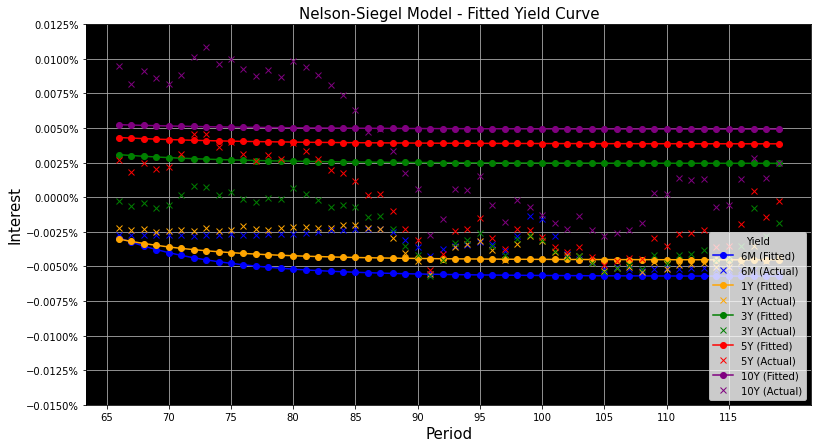

In [30]:
# Create a copy of the transposed DataFrame
sf = y.copy()

# Drop any rows with missing values
sf = sf.dropna()

# Create a copy of the DataFrame sf
sf1 = sf.copy()

# Multiply by 100 to convert to percentage and round to 4 decimal places
sf1['Y'] = round(sf1['6M'] * 100, 4)

# Define columns to plot
columns_to_plot = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Plotting
fig, ax = plt.subplots(figsize=(13, 7))
plt.title("Nelson-Siegel Model - Fitted Yield Curve", fontsize=15)
ax.set_facecolor("black")
fig.patch.set_facecolor('white')

# Define colors for each column
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Plot each column from sf1 and test_data
for idx, col in enumerate(columns_to_plot):
    X = sf1.index
    Y = sf1[col]  # Fitted data
    plt.plot(X, Y, label=f"{col} (Fitted)", marker="o", color=colors[idx])
    
    i = test_data.index
    k = test_data[col]  # Test data for the same maturity
    plt.plot(i, k, marker='x', linestyle='None', label=f"{col} (Actual)", color=colors[idx])

plt.xlabel('Period', fontsize=15)
plt.ylabel('Interest', fontsize=15)
plt.xticks(np.arange(65, 120, 5))
plt.yticks(np.arange(-0.015, 0.015, 0.0025))
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(title="Yield", loc="lower right")
plt.grid()
plt.show()


### Random walk

In [32]:
#benchmark random walk
def random_walk(series, months):
    k = series.iloc[-1]
    rf = np.random.normal(0, series.std(), months)
    predic = k + np.cumsum(rf)
    return predic


maturities = ["6M", "1Y", "3Y", "5Y", "10Y"]

Y = train_data

Y = Y.values

forecast_results_df = pd.DataFrame(index=maturities, columns=range(1, 55))

for maturity in maturities:
    series = train_data[maturity]

    for horizon in range(1, 55):
        forecast_key = f'Maturity_{maturity}Horizon{horizon}'

        # Expanding window forecast

        forecast = random_walk(series, horizon)

        forecast_results_df.loc[maturity, horizon] = forecast


#12 months a head forecasting
print(forecast_results_df.iloc[:,12])

MSE2=np.mean((test_data.iloc[:12,0]-forecast_results_df.iloc[0,11])**2)
print(f"The MSE of treasury maturity of 6 months",MSE2)

6M     [-0.007383261812085604, -0.017192719176626, -0...
1Y     [-0.0006312781982394068, -0.004683776025509238...
3Y     [-0.003386796495748771, -0.0014277353159874529...
5Y     [0.004781163800091131, -0.007321882793653173, ...
10Y    [0.008925046144465584, -0.00064460908333187, -...
Name: 13, dtype: object
The MSE of treasury maturity of 3 months 4.8916209400904274e-05


### Vasicek model

In [74]:
def getSimRate(kappa, mu, sigma, r0, R, delta, T0, T1):
    #nsteps = int(T0 / delta)
    nsteps = int(T1-T0+1)
    dVarSR = (sigma**2) * (1 - np.exp(-2 * kappa * delta)) / (2 * kappa)  # short rate variance
    mR = np.zeros((R, nsteps))

    for r in range(R):
        mR[r, 0] = r0
        for i in range(1, nsteps):
            mR[r, i] = np.exp(-kappa * delta) * mR[r, i - 1] + \
                (1 - np.exp(-kappa * delta)) * mu + \
                np.random.normal(0, np.sqrt(dVarSR))
    
    return mR


In [110]:
# Simulation parameters
R = 100     # Number of simulations (paths)
delta = 1/12  # Time step size (1 month)
T0 = 1       # Time to start of simulation
T1 = 54      # Time to end of simulation

def find_optimal_kappa(train_data, test_data, kappa_range):
    min_mse = float('inf')
    optimal_kappa = None

    for kappa_val in kappa_range:
        mse_values = []

        for column in train_data.columns:
            # Define Vasicek model parameters for each column
            mu = np.mean(train_data[column])
            sigma = np.std(train_data[column])
            r0 = train_data[column].iloc[-1]  # Initial short rate

            # Call getSimRate function to simulate short rate paths
            mR = getSimRate(kappa_val, mu, sigma, r0, R, delta, T0, T1)

            # Calculate mean squared error for the current column
            squared_diff = (np.mean(mR, axis=0) - test_data[column]) ** 2
            mse = np.mean(squared_diff)
            mse_values.append(mse)

        # Calculate average mean squared error across all columns
        avg_mse = np.mean(mse_values)

        # Update optimal kappa and min_mse if current kappa yields lower MSE
        if avg_mse < min_mse:
            min_mse = avg_mse
            optimal_kappa = kappa_val

    return optimal_kappa, min_mse

# Define the range of kappa values to search over
kappa_range = np.arange(0.1, 3.0, 0.1)

# Call the function to find the optimal kappa
optimal_kappa, min_mse = find_optimal_kappa(train_data, test_data, kappa_range)

print("Optimal kappa:", optimal_kappa)
print("Minimum Mean Squared Error:", min_mse)


Optimal kappa: 0.1
Minimum Mean Squared Error: 2.552169859333811e-05


In [108]:
# Define the index range
index_range = range(54)

# Define the column names
column_names = ["6M", "1Y", "3Y", "5Y", "10Y"]

# Create the DataFrame
df = pd.DataFrame(index=index_range, columns=column_names)

mse_values2=[]
kappa=0.1 # as it is the optimal
R = 1000     # Number of simulations (paths)
delta = 1/12  # Time step size (1 month)
T0 = 1       # Time to start of simulation
T1 = 54      # Time to end of simulation

for column in train_data.columns:
    
    # Define Vasicek model parameters for each maturity
    mu = np.mean(train_data[column])
    sigma = np.std(train_data[column])
    r0 = train_data[column].iloc[-1]  # Initial short rate

    # Call getSimRate function to simulate short rate paths
    mR = getSimRate(kappa, mu, sigma, r0, R, delta, T0, T1)
    r=np.mean(mR, axis=0)
    df[column]=r
    # Calculate mean squared error for the current column
    squared_diff = (r - test_data[column]) ** 2
    mse = np.mean(squared_diff)
    mse_values2.append(mse)

# Calculate average mean squared error across all columns
    avg_mse = np.mean(mse_values2)

In [109]:
print("Average Mean Squared Error:", avg_mse)

Average Mean Squared Error: 2.281117262834351e-05
